<a href="https://colab.research.google.com/github/steventango/cmput-428-project/blob/main/circreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import leastsq, minimize
from scipy.optimize import NonlinearConstraint as NC
import cv2
from time import time
from scipy.stats import linregress

from mpl_toolkits import mplot3d

[-1.10872782 -4.47147111]
Time taken: 0.02698373794555664


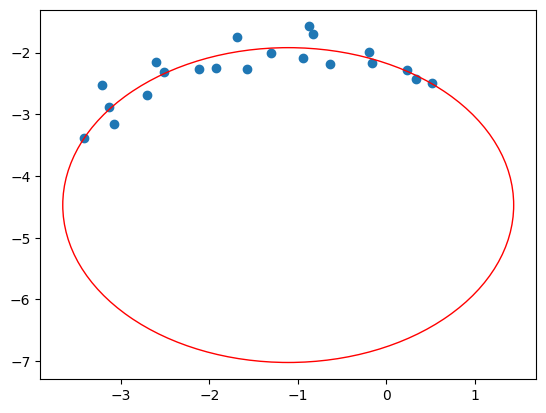

In [11]:
# standard circreg

rng = np.random.default_rng()
mu, sig, n = 0, 0.2, 21
t = np.linspace(1, 2.5, n)
x = [3*np.cos(t) - 1 + rng.normal(mu, sig, n)]
y = [3*np.sin(t) - 5 + rng.normal(mu, sig, n)]

a = 0
c = np.cos(a)
s = np.sin(a)
coords = np.array([[c, -s], [s, c]]) @ np.concatenate((x, y), axis=0)
x = coords[0]
y = coords[1]

xc = np.mean(x)
yc = np.mean(y)

def d(c):
  # optimize sum of squares of distances to mean circle
  r = np.sqrt((x-c[0])**2+(y-c[1])**2)
  return r - np.mean(r)

def f(c):
  return np.sum(d(c)**2)

def g(c):
  # constraint
  return np.mean(np.sqrt((x-c[0])**2+(y-c[1])**2)) - np.sqrt((x[-1]-c[0])**2+(y[-1]-c[1])**2)


start = time()

# plot circle
c = minimize(f, [xc, yc], method="L-BFGS-B").x
print(c)
r = np.mean(np.sqrt((x-c[0])**2+(y-c[1])**2))
circ = plt.Circle(c, r, color='r', fill=False)
fig1, ax1 = plt.subplots()
ax1.scatter(x, y)
ax1.add_patch(circ)
'''
# project onto circle
tmeas = np.arctan((y - c[1])/(x - c[0])) + np.where(x < c[0], np.pi, 0)
ax1.scatter(r*np.cos(tmeas) + c[0], r * np.sin(tmeas) + c[1])

# linreg to extrapolate points on circle
fig2, ax2 = plt.subplots()
num = np.arange(1, n+1)
ax2.scatter(num, tmeas)
m, b, _, _, _ = linregress(num, tmeas)
ax2.plot([0, n+1], [b, m*(n+1)+b])

npreds = 5
numpred = num[-1] + np.arange(1, npreds+1)
tpred = m * numpred + b
ax2.scatter(numpred, tpred)
ax1.scatter(r*np.cos(tpred) + c[0], r * np.sin(tpred) + c[1])

plt.show()
'''
print("Time taken: " + str(time() - start))

In [ ]:
# slack circreg

rng = np.random.default_rng()
mu, sig, n = 0, 0.2, 21
t = np.linspace(1, 2.5, n)
x = [3*np.cos(t) - 1 + rng.normal(mu, sig, n)]
y = [3*np.sin(t) - 5 + rng.normal(mu, sig, n)]



(2, 11)
0.5720469859597596 0.0075400468805076086
[ 1.13234521  2.21591813  3.28465006  4.6351031   6.20316386  7.83482711
  9.8063221  11.8385347  14.14033264 16.46138992 19.05545354]
[21.80942122 24.7382356  27.84189669 31.12040447 34.57375895]


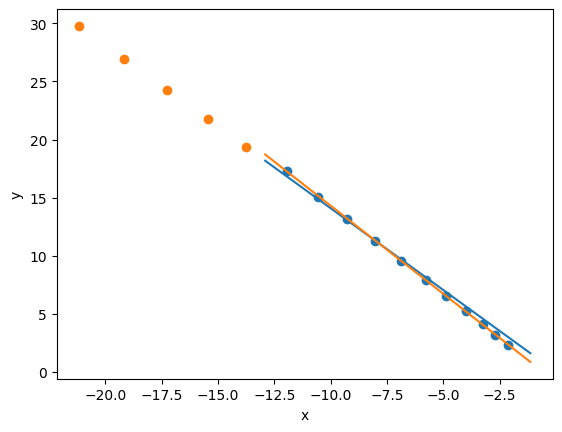

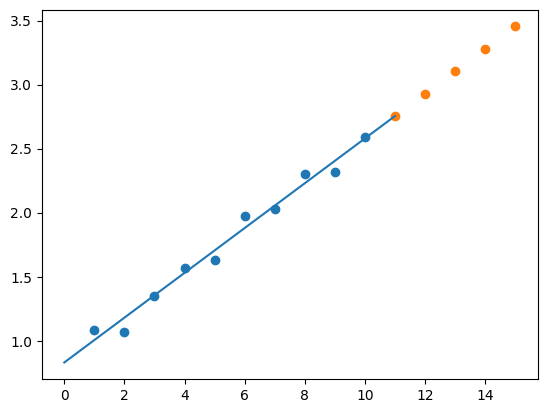

Time taken: 0.5691878795623779


In [81]:
# standard linreg

rng = np.random.default_rng()
mu, sig, n = 0, 0.05, 11
xo = np.array(np.linspace(1, 3, n)**2)
y = [2*xo + 1 + rng.normal(mu, sig, n)]
x = [xo + rng.normal(mu, sig, n)]
a = np.pi/3
c = np.cos(a)
s = np.sin(a)
coords = np.array([[c, -s], [s, c]]) @ np.concatenate((x, y), axis=0)
print(np.shape(coords))
x = coords[0]
y = coords[1]

xc = np.mean(x)
yc = np.mean(y)


def f(l):
  # optimize sum of squared distances to line
  return np.sum((np.array([l[0], l[1], 1]) @ np.concatenate((coords, np.ones_like([x])), axis=0))**2) / (l[0]**2 + l[1]**2)

start = time()

# total lstsq in blue
#p = minimize(f, [-np.tan(np.arctan(2) + np.pi/6)/7, 1/7], method="trust-constr").x
p = minimize(f, [3, -50], method="trust-constr").x




# regular linreg in orange
m, b, _, _, _ = linregress(x, y)
print(f(p), f([m/b, -1/b]))

fig1, ax1 = plt.subplots()
ax1.scatter(x, y)

# plot fitted line
wx = max(x) - min(x)
xmin = min(x) - 0.1*wx
xmax = max(x) + 0.1*wx
ymin = (p[0] * xmin + 1) / (-p[1])
ymax = (p[0] * xmax + 1) / (-p[1])
ax1.plot([xmin, xmax], [ymin, ymax])
ax1.plot([xmin, xmax], [m*xmin+b, m*xmax+b])
ax1.set(xlabel='x', ylabel='y')

if x[-1] > x[0]:
  xstart, ystart, xend, yend = xmin, ymin, xmax, ymax
else:
  xend, yend, xstart, ystart = xmin, ymin, xmax, ymax
vecs = (coords - np.array([[xstart], [ystart]])).T
dir = np.array([xend - xstart, yend - ystart])
dir = dir / np.linalg.norm(dir)
dists = vecs @ dir
print(dists)
incs = np.diff(dists)

fig2, ax2 = plt.subplots()
t = np.arange(1, n)
ax2.scatter(t, incs)
m, b, _, _, _ = linregress(t, incs)
ax2.plot([0, n], [b, m*n+b])

npreds = 5
tpred = t[-1] + np.arange(1, npreds+1)
incpred = m * tpred + b
distpred = dists[-1] + np.cumsum(incpred)
xpred = xstart + distpred * dir[0]
print(distpred)

# plot predicted points in orange
ax2.scatter(tpred, incpred)
ax1.scatter(xpred, (p[0] * xpred + 1) / (-p[1]))

plt.show()

print("Time taken: " + str(time() - start))

(2, 11)
-5.312592316689551 0.7529280926439559 996.0522709305491 53.02311786474227 63.10729049720213


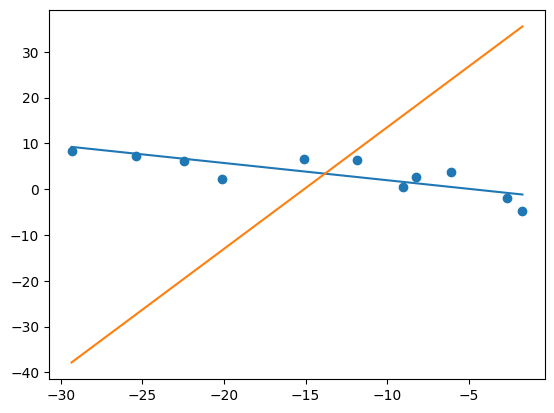

In [99]:
rng = np.random.default_rng()
mu, sig, n = 0, 3, 11
xo = np.array(np.linspace(1, 3, n)**2)
y = [3*xo + 1 + rng.normal(mu, sig, n)]
x = [xo + rng.normal(mu, sig, n)]
a = np.pi/2
c = np.cos(a)
s = np.sin(a)
coords = np.array([[c, -s], [s, c]]) @ np.concatenate((x, y), axis=0)
print(np.shape(coords))
x = coords[0]
y = coords[1]

def C(d1, d2):
  return np.sum((d1 - np.mean(d1))*(d2 - np.mean(d2)))
 
Cxx = C(x, x)
Cxy = C(x, y)
Cyy = C(y, y)
rx = x - np.mean(x)
ry = y - np.mean(y)

def f(A, B):
  return np.sum((A * rx + B * ry)**2) / (A**2 + B**2)

def A(B):
  Ap = B*(Cxx - Cyy + np.sqrt((Cxx - Cyy)**2 + 4*Cxy**2)) / (2*Cxy)
  Am = B*(Cxx - Cyy - np.sqrt((Cxx - Cyy)**2 + 4*Cxy**2)) / (2*Cxy)
  if f(Ap, B) < f(Am, B):
    return Ap
  return Am

def A2(B):
  Ap = B*(Cxx - Cyy + np.sqrt((Cxx - Cyy)**2 + 4*Cxy**2)) / (2*Cxy)
  Am = B*(Cxx - Cyy - np.sqrt((Cxx - Cyy)**2 + 4*Cxy**2)) / (2*Cxy)
  print(Ap, Am, f(Ap, B), f(Am, B), f(1, B))
  if f(Ap, B) > f(Am, B):
    return Ap
  return Am

B=2

fig, ax = plt.subplots()
ax.scatter(x, y)
xplt = np.array([min(x), max(x)])
ax.plot(xplt, -A(B)*(xplt - np.mean(x))/B + np.mean(y))
ax.plot(xplt, -A2(B)*(xplt - np.mean(x))/B + np.mean(y))


[ 3.99430675  4.95211095  5.98356008  3.0004022  -2.25743264 -0.01048556
 -0.74272888] 0.13242175262088698


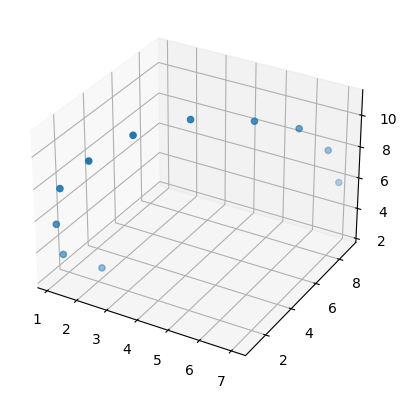

In [138]:
rng = np.random.default_rng()
mu, sig, n = 0, 0.1, 11
t = np.linspace(0, 4, n)
x = 3*np.cos(t) + 4 + rng.normal(mu, sig, n)
y = 4*np.cos(t) + 5 + rng.normal(mu, sig, n)
z = 5*np.sin(t) + 6 + rng.normal(mu, sig, n)
xc, yc, zc = np.mean(x), np.mean(y), np.mean(z)

c = minimize(f, [xc, yc, zc, 1, -1, 1, -1], 
             method='trust-constr',constraints=NC(g, 0, 0)).x
print(c, f(c))

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
ax.scatter(x, y, z)
plt.show()

In [129]:
def proj(v, n):   # n should be one vector, v can be many
  return np.outer(n, (n @ v) / np.dot(n, n))

def dc(c, xyz):
  # optimize sum of squares of distances to mean circle
  r = np.sqrt((xyz[0]-c[0])**2+(xyz[1]-c[1])**2+(xyz[2]-c[2])**2)
  return r - np.mean(r)

def f(cn):
  # cn[0:3] for sphere center, cn[3:6] for plane normal, cn[6] for plane constant
  try:
    plpt = [-cn[6]/cn[3], 0, 0]
  except ZeroDivisionError:
    try:
      plpt = [0, -cn[6]/cn[4], 0]
    except ZeroDivisionError:
      plpt = [0, 0, -cn[6]/cn[5]]

  vec = np.array([x, y, z]) - np.array([plpt]).T
  projnv = proj(vec, cn[3:6])
  oprojnv = vec - projnv
  return np.sum(dc(cn[0:3] - plpt, oprojnv)**2) + np.sum(np.linalg.norm(projnv, axis=0)**2)

def g(cn):
  return np.dot(cn[0:3], cn[3:6]) + cn[6]

0.04882244067354636


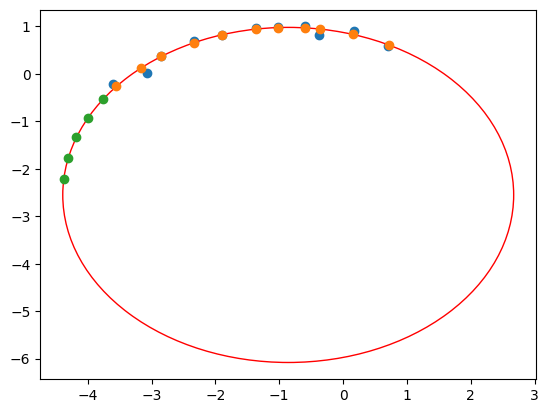

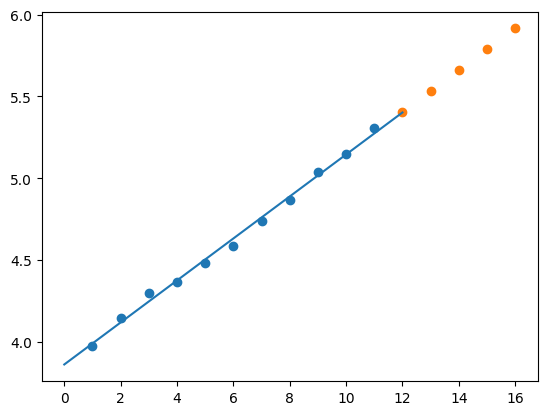

Time taken: 0.9205200672149658


In [110]:
rng = np.random.default_rng()
mu, sig, n = 0, 0.1, 11
t = np.linspace(1, 2.5, n)
x = [3*np.cos(t) - 1 + rng.normal(mu, sig, n)]
y = [3*np.sin(t) - 2 + rng.normal(mu, sig, n)]

def f(p):
  return np.sum((x-p[n]*np.cos(p[0:n] + p[n+3])-p[n+1])**2 + (y-p[n]*np.sin(p[0:n] + p[n+3])-p[n+2])**2)

def g(p):
  return int(np.all(p >= 0) and np.all(p < 2*np.pi))

start = time()
init = np.concatenate((t+np.pi, np.array([2, 1, 2, 0])))
p = minimize(f, init, method="L-BFGS-B").x
tmeas = p[0:n]
r = p[n]
c = (p[n+1], p[n+2])
off = p[n+3]
print(f(p))

fig1, ax1 = plt.subplots()
ax1.scatter(x, y)
circ = plt.Circle(c, r, color='r', fill=False)
ax1.add_patch(circ)
ax1.scatter(r*np.cos(tmeas + off) + c[0], r * np.sin(tmeas + off) + c[1])

fig2, ax2 = plt.subplots()
num = np.arange(1, n+1)
ax2.scatter(num, tmeas)
m, b, _, _, _ = linregress(num, tmeas)
ax2.plot([0, n+1], [b, m*(n+1)+b])

npreds = 5
numpred = num[-1] + np.arange(1, npreds+1)
tpred = m * numpred + b
ax2.scatter(numpred, tpred)
ax1.scatter(r*np.cos(tpred + off) + c[0], r * np.sin(tpred + off) + c[1])

plt.show()

print("Time taken: " + str(time() - start))